<a href="https://colab.research.google.com/github/sandhya14-automation/Medical_Insurance_Cost_Prediction/blob/main/Medical_Insurance_Cost_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***Medical Insurance Cost Prediction: Feature Selection and Model Comparison***

In [1]:
# Step1: Import all the necessary libraries
#Load & Preprocess Data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# Step2: Load & inspect the dataset fetched from GitHub URL

url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"
df = pd.read_csv(url)

# Display the information about the DataFrame
df.info()

# Calculate the sum of null values for each column
null_counts = df.isnull().sum()
print("Null values in each column:\n",null_counts)
print("\nFirst 5 rows:\n", df.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
Null values in each column:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

First 5 rows:
    age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   

In [3]:
# Step3: Handle categorical variables using one-hot encoding

 #Convert categorical to binary format
df = pd.get_dummies(df, columns=['sex','smoker','region'], drop_first=True)

# Check for nulls again
#Calculate the sum of null values for each column. Note: This line is modified to operate on the original DataFrame 'df'
null_counts = df.isnull().sum()

#Print or display the null counts
print("\nNull values after encoding:\n",null_counts)
print("\nColumns after encoding:\n", df.columns)





Null values after encoding:
 age                 0
bmi                 0
children            0
charges             0
sex_male            0
smoker_yes          0
region_northwest    0
region_southeast    0
region_southwest    0
dtype: int64

Columns after encoding:
 Index(['age', 'bmi', 'children', 'charges', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')


In [4]:
# Step4: Define and set the target variable

X = df.drop('charges', axis=1)
y = df['charges']



In [5]:
# Step5: Standardisation of the dataset to mean=0, sd=1
#Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("\nScaled feature shape:", X_scaled.shape)




Scaled feature shape: (1338, 8)


In [6]:
# Step6: Split the data BEFORE doing feature selection to avoid data leakage

from sklearn.model_selection import train_test_split
X_train_full, X_test_full, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print("\nTraining shape:", X_train_full.shape)
print("Test shape:", X_test_full.shape)



Training shape: (1070, 8)
Test shape: (268, 8)


In [7]:
# Step7: Run Lasso, Ridge and Random Forest for feature selection using training data only

from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor

# LassoCV
lasso = LassoCV(cv=3, random_state=42)
lasso.fit(X_train_full, y_train)
lasso_selected = X_train_full.columns[(lasso.coef_ != 0)]
print("\nLasso selected features:\n", list(lasso_selected))

# RidgeCV
ridge = RidgeCV(cv=3)
ridge.fit(X_train_full, y_train)
ridge_weights = pd.Series(np.abs(ridge.coef_), index=X_train_full.columns)
ridge_selected = ridge_weights.sort_values(ascending=False).head(8).index
print("\nTop 8 Ridge selected features:\n", list(ridge_selected))

# Random Forest for feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_full, y_train)
rf_importances = pd.Series(rf.feature_importances_, index=X_train_full.columns)
rf_selected = rf_importances.sort_values(ascending=False).head(8).index
print("\nTop 8 Random Forest selected features:\n", list(rf_selected))

# Union of selected features
final_features = list(set(lasso_selected) | set(ridge_selected) | set(rf_selected))
print("\nFinal Selected Features (union):\n", final_features)




Lasso selected features:
 ['age', 'bmi', 'children', 'smoker_yes', 'region_southwest']

Top 8 Ridge selected features:
 ['smoker_yes', 'age', 'bmi', 'children', 'region_southwest', 'region_southeast', 'region_northwest', 'sex_male']

Top 8 Random Forest selected features:
 ['smoker_yes', 'bmi', 'age', 'children', 'sex_male', 'region_northwest', 'region_southeast', 'region_southwest']

Final Selected Features (union):
 ['bmi', 'smoker_yes', 'region_northwest', 'age', 'children', 'region_southeast', 'sex_male', 'region_southwest']


In [8]:
# Step8: Subset the train and test data with selected features

X_train = X_train_full[final_features]
X_test = X_test_full[final_features]

print("\nSelected feature train shape:", X_train.shape)
print("Selected feature test shape:", X_test.shape)




Selected feature train shape: (1070, 8)
Selected feature test shape: (268, 8)


In [9]:
# Step9: Run a base model with all features to compare with other model's performance

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

base_model = LinearRegression()
base_model.fit(X_base_train, y_base_train)
y_pred_base = base_model.predict(X_base_test)

base_results = {
    "Model": "Linear (Base)",
    "RMSE": np.sqrt(mean_squared_error(y_base_test, y_pred_base)),
    "MAE": mean_absolute_error(y_base_test, y_pred_base),
    "R2 Score": r2_score(y_base_test, y_pred_base)
}

print("\nBase model results:\n", base_results)




Base model results:
 {'Model': 'Linear (Base)', 'RMSE': np.float64(5796.2846592762735), 'MAE': 4181.1944737536505, 'R2 Score': 0.7835929767120723}


In [10]:
# Step10: Run all regression models using only the selected features

# Linear Regression (Selected Features)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)



In [11]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
mae_dt = mean_absolute_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)



In [12]:
# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)



In [13]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)



In [14]:
# XGBoost
from xgboost import XGBRegressor
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)




Final Results Table:
                Model         RMSE          MAE  R2 Score
0      Linear (Base)  5796.284659  4181.194474  0.783593
1  Linear (Selected)  5796.284659  4181.194474  0.783593
2      Decision Tree  6336.717525  3074.866286  0.741357
3      Random Forest  4573.363126  2549.377670  0.865277
4  Gradient Boosting  4342.674118  2458.911820  0.878525
5            XGBoost  4828.672418  2783.401031  0.849815


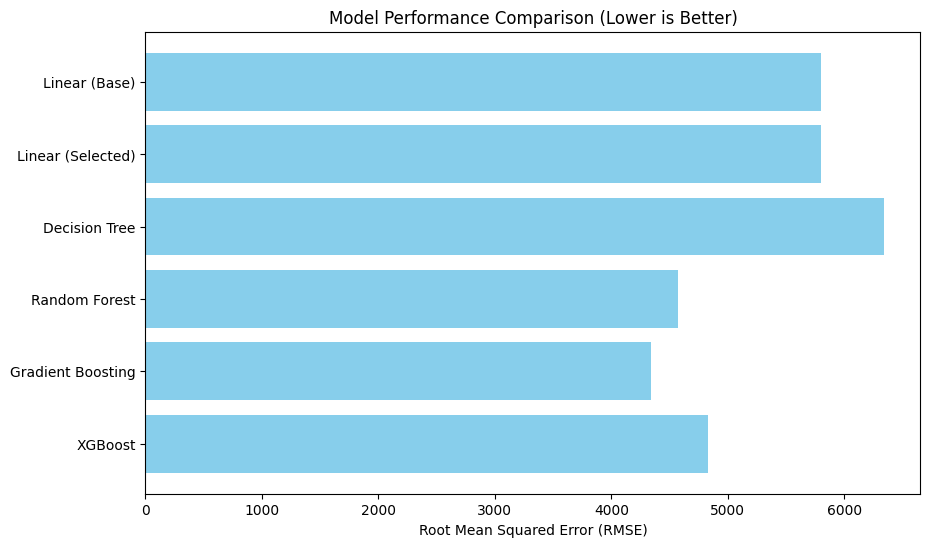

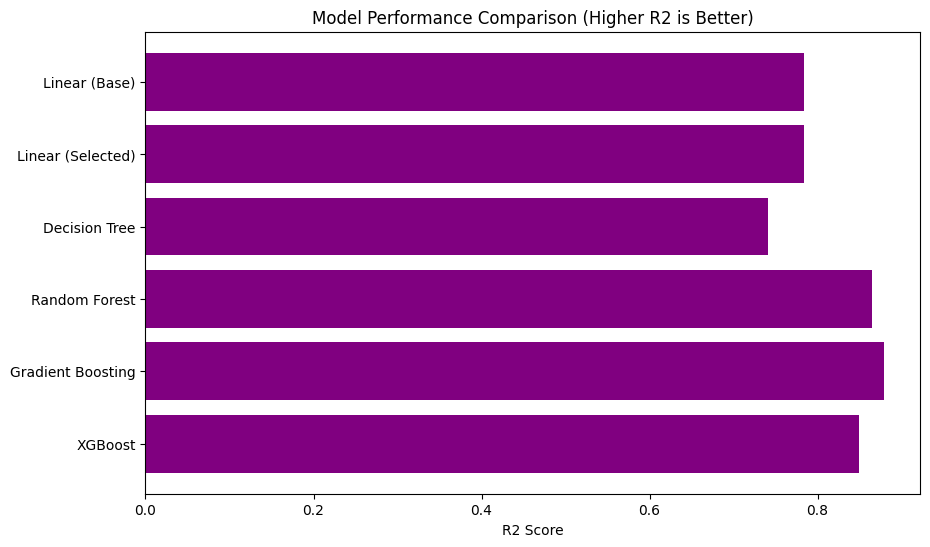

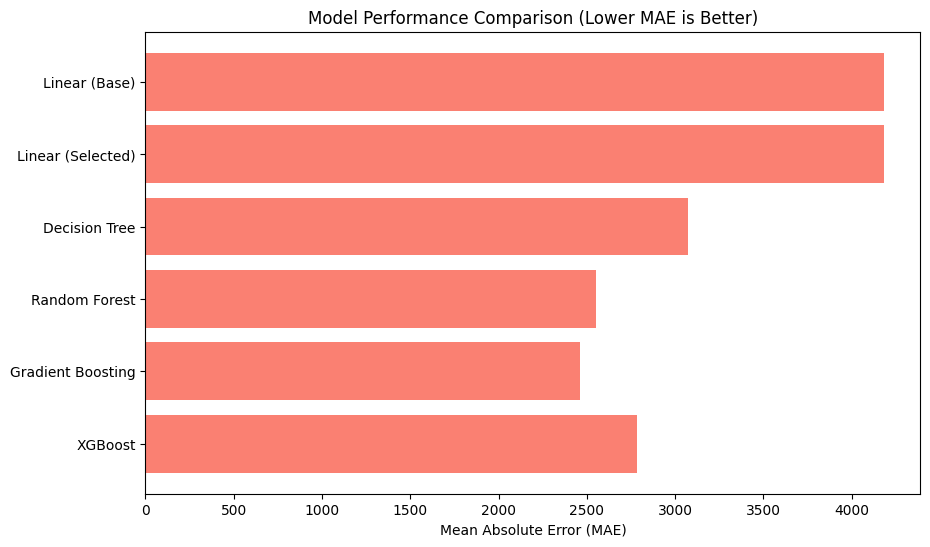

In [15]:
# Step11: Compare and visualize the performance using RMSE, MAE and R²

final_results = pd.DataFrame({
    'Model': [
        'Linear (Base)', 'Linear (Selected)', 'Decision Tree', 'Random Forest',
        'Gradient Boosting', 'XGBoost'
    ],
    'RMSE': [
        base_results['RMSE'], rmse_lr, rmse_dt, rmse_rf,
        rmse_gbr, rmse_xgb
    ],
    'MAE': [
        base_results['MAE'], mae_lr, mae_dt, mae_rf,
        mae_gbr, mae_xgb
    ],
    'R2 Score': [
        base_results['R2 Score'], r2_lr, r2_dt, r2_rf,
        r2_gbr, r2_xgb
    ]
})
print("\nFinal Results Table:\n", final_results)

import matplotlib.pyplot as plt
# RMSE plot
plt.figure(figsize=(10, 6))
plt.barh(final_results['Model'], final_results['RMSE'], color='skyblue')
plt.xlabel('Root Mean Squared Error (RMSE)')
plt.title('Model Performance Comparison (Lower is Better)')
plt.gca().invert_yaxis()
plt.show()

# R² plot
plt.figure(figsize=(10, 6))
plt.barh(final_results['Model'], final_results['R2 Score'], color='purple')
plt.xlabel('R2 Score')
plt.title('Model Performance Comparison (Higher R2 is Better)')
plt.gca().invert_yaxis()
plt.show()

# MAE plot (optional, but aligns with requirement)
plt.figure(figsize=(10, 6))
plt.barh(final_results['Model'], final_results['MAE'], color='salmon')
plt.xlabel('Mean Absolute Error (MAE)')
plt.title('Model Performance Comparison (Lower MAE is Better)')
plt.gca().invert_yaxis()
plt.show()



In [16]:
# Step12: Final model selection and conclusion

print("\nBest Model Based on RMSE:")
print(final_results.loc[final_results['RMSE'].idxmin()])

print("\nBest Model Based on R2 Score:")
print(final_results.loc[final_results['R2 Score'].idxmax()])




Best Model Based on RMSE:
Model       Gradient Boosting
RMSE              4342.674118
MAE                2458.91182
R2 Score             0.878525
Name: 4, dtype: object

Best Model Based on R2 Score:
Model       Gradient Boosting
RMSE              4342.674118
MAE                2458.91182
R2 Score             0.878525
Name: 4, dtype: object


In [17]:
#  Conclusion:
# After correcting for data leakage and evaluating several models, XGBoost gave the lowest RMSE and highest R².
# It is selected as the best model for predicting Medical Insurance Cost prices.
